In [1]:
import numpy as np
import pandas as pd
import random
import category_encoders as ce
import os
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

import BTC_Cell_Line_Atlas_Manuscript.scripts.io_library as io_library
io_library.input_dir = 'input_data/'
io_library.output_dir = 'Figure4/output_fig4/'

from BTC_Cell_Line_Atlas_Manuscript.scripts.io_library import MyLib
from BTC_Cell_Line_Atlas_Manuscript.scripts.differential_dependency import DifferentialDependency
from BTC_Cell_Line_Atlas_Manuscript.scripts.utils import Utils
from BTC_Cell_Line_Atlas_Manuscript.scripts.clustering_utils import Clustering
from BTC_Cell_Line_Atlas_Manuscript.scripts.visualization import MyVisualization

In [2]:
import matplotlib
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

In [3]:
gene_effect_file = 'Main_Data/CRISPR/CRISPR.csv'
gene_effect_df = MyLib.load_csv(gene_effect_file, index_col=0)
gene_effect_df = gene_effect_df.T
gene_effect_df = gene_effect_df.dropna(axis=1)

genes_exclude_file = 'Additional_Data/Selected_Lists/all_common_genes.csv'
genes_exclude = MyLib.load_csv(genes_exclude_file)['Gene'].tolist()
gene_effect_filtered_df = gene_effect_df.loc[:, ~gene_effect_df.columns.isin(genes_exclude)]

upset_file = 'cell_lines_master_upset_2024-4-13.csv'
raw_upset_df = MyLib.load_csv(upset_file)
raw_upset_df.set_index('Cell_line', inplace=True, drop=True)
upset_df = raw_upset_df[raw_upset_df['CRISPR']==1]
upset_df = upset_df[["Subtype"]]

gene_effect_filtered_df = gene_effect_filtered_df.loc[upset_df.index,:]
gene_effect_filtered_df = gene_effect_filtered_df.rename(columns={c:c.split(' (')[0] for c in gene_effect_df.columns})
gene_effect_filtered_df.shape

input_data/Main_Data/CRISPR/CRISPR.csv  is loaded, shape:  (18443, 60)

input_data/Additional_Data/Selected_Lists/all_common_genes.csv  is loaded, shape:  (2577, 1)

input_data/cell_lines_master_upset_2024-4-13.csv  is loaded, shape:  (87, 11)



(60, 15308)

# Filtration

In [4]:
var_df = Clustering.select_top_variable_features(gene_effect_filtered_df, top_k=100)
var_df.shape

(60, 100)

In [5]:
cosmic_file = 'Additional_Data/Selected_Lists/cosmic/Census_allFri Dec 22 20_09_34 2023.csv'
cosmic_df = MyLib.load_csv(cosmic_file, index_col=0)

cosmic_df = cosmic_df[cosmic_df['Hallmark'] == 'Yes']
hallmark_l = cosmic_df.index.tolist()
hallmark_l = sorted(set(hallmark_l).intersection(gene_effect_filtered_df.columns.tolist()))
len(hallmark_l)

input_data/Additional_Data/Selected_Lists/cosmic/Census_allFri Dec 22 20_09_34 2023.csv  is loaded, shape:  (743, 19)



291

(291,)


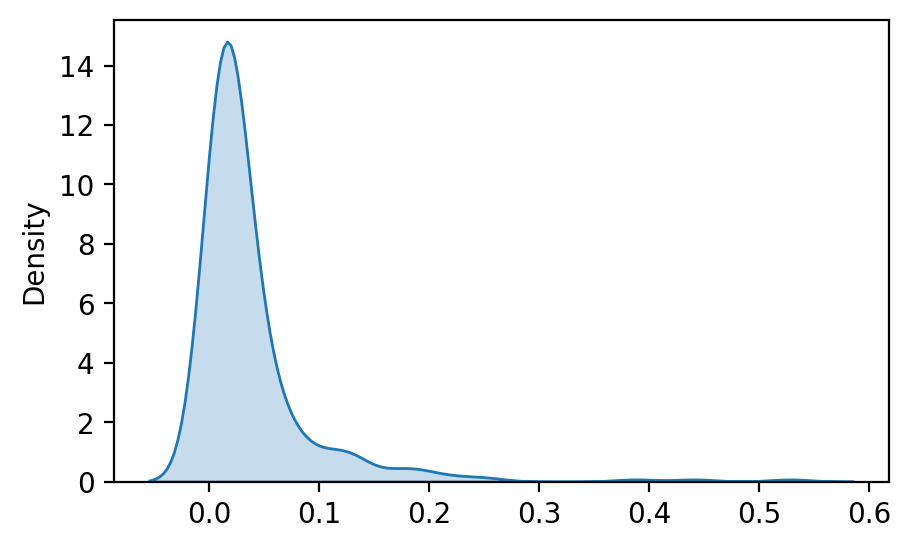

In [6]:
var_sr = gene_effect_filtered_df[hallmark_l].var(axis=0)
print(var_sr.shape)
MyVisualization.plot_distribution(var_sr)

In [7]:
hm_df = Clustering.drop_low_vars(gene_effect_filtered_df[hallmark_l], threshold=0.1)
hm_df.shape

(60, 27)

In [8]:
pref_file = 'Additional_Data/Selected_Lists/BTC_Preferential Dependencies.csv'
pref_l = MyLib.load_csv(pref_file, index_col=0).index.tolist()
pref_l = [g for g in pref_l if g in gene_effect_filtered_df.columns]
len(pref_l)

input_data/Additional_Data/Selected_Lists/BTC_Preferential Dependencies.csv  is loaded, shape:  (696, 1)



620

In [9]:
lrt_file = 'Additional_Data/Selected_Lists/lrt_table.csv'
lrt_df = MyLib.load_csv(lrt_file)
lrt_df = lrt_df[lrt_df['skewed_left']]
lrt_df.reset_index(inplace=True, drop=True)
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.split('..')[0]+' ('+x.split('..')[1]+')').apply(lambda x:x.replace('.)', ')'))
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.replace('.', '-'))
lrt_df['name'] = lrt_df['gene'].apply(lambda x:x.split()[0])
threshold = np.percentile(lrt_df['lrt'].dropna(), 98)

genes_lrt_l = [g for g in lrt_df[lrt_df['lrt']> round(threshold)]['name'].tolist() if g in gene_effect_filtered_df.columns]
gene_effect_lrt_df = gene_effect_filtered_df[genes_lrt_l]
gene_effect_lrt_df.shape

input_data/Additional_Data/Selected_Lists/lrt_table.csv  is loaded, shape:  (18443, 5)



(60, 193)

In [10]:
genes_l = sorted(set(pref_l).union(var_df.columns.tolist()).union(set(hm_df.columns)).union(gene_effect_lrt_df.columns))
gene_effect_filtered_df2 = gene_effect_filtered_df[genes_l].copy()

gene_effect_filtered_df2.shape

(60, 772)

In [11]:
encoder = ce.OneHotEncoder(use_cat_names=True)
subtype_df = encoder.fit_transform(upset_df['Subtype'])
subtype_df

,Subtype_AC,Subtype_ECC,Subtype_GBC,Subtype_HCC,Subtype_ICC
Cell_line,,,,,
SNU869,1,0,0,0,0
SNU478,1,0,0,0,0
TGBC52TKB,1,0,0,0,0
AOVC1,1,0,0,0,0
TGBC18TKB,1,0,0,0,0
SNU1196,0,1,0,0,0
EGI1,0,1,0,0,0
KKU100,0,1,0,0,0
TFK1,0,1,0,0,0


# Subtype differential dependency

## AC

In [12]:
group =  'Subtype_AC'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, subtype_df, test='ttest', group=group)

Subtype_AC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/Subtype_AC_all_features_stats.csv saved, shape: (772, 6)


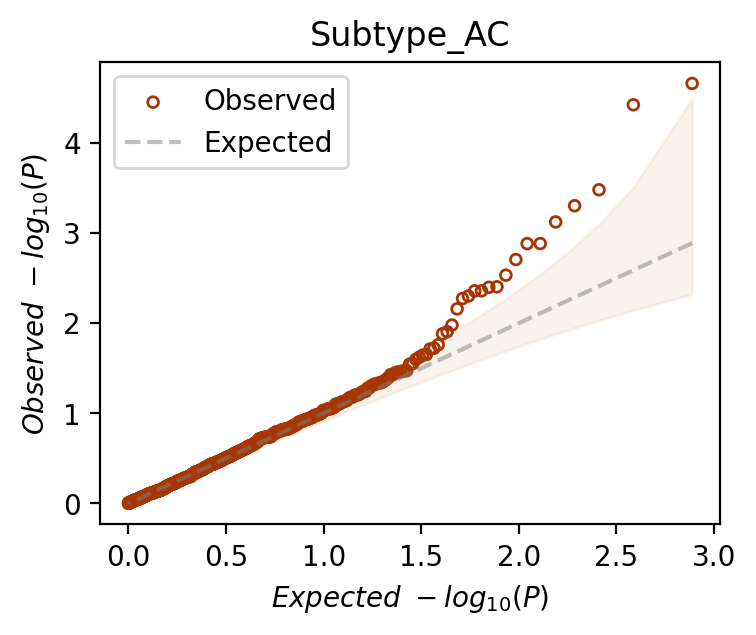

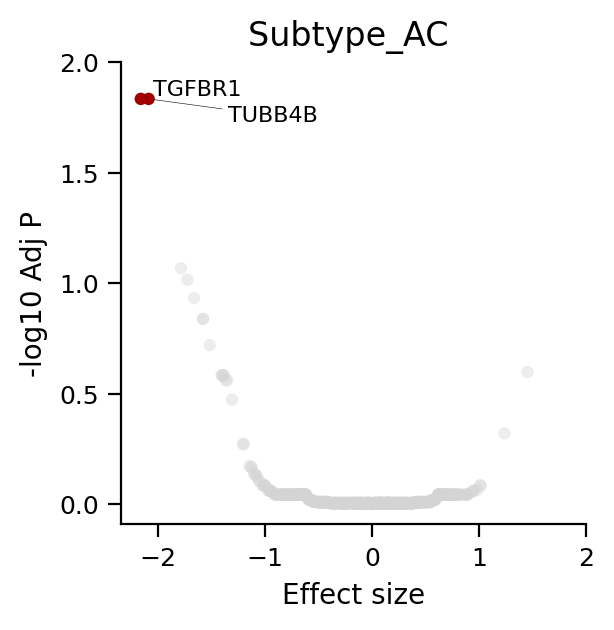


File  Figure4/output_fig4/Subtype_AC_features_Down_.csv saved, shape: (2, 5)


In [13]:
AC_features = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', return_features=True,  ylim_top=2, ytick_step=.5, xlim_right=2, top_labels_cutoff=0)# xtick_step=2,xlim_left=-5,

## ECC

In [14]:
group =  'Subtype_ECC'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, subtype_df, test='ttest', group=group)

Subtype_ECC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/Subtype_ECC_all_features_stats.csv saved, shape: (772, 6)


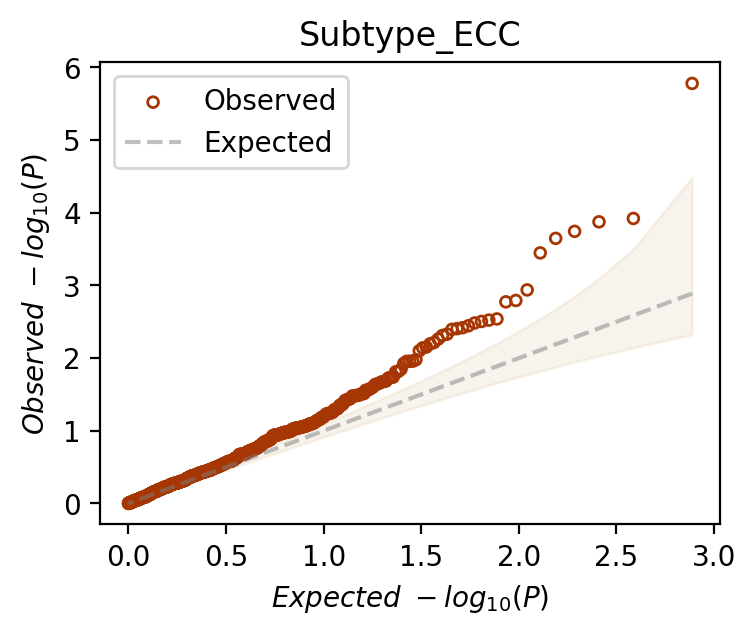

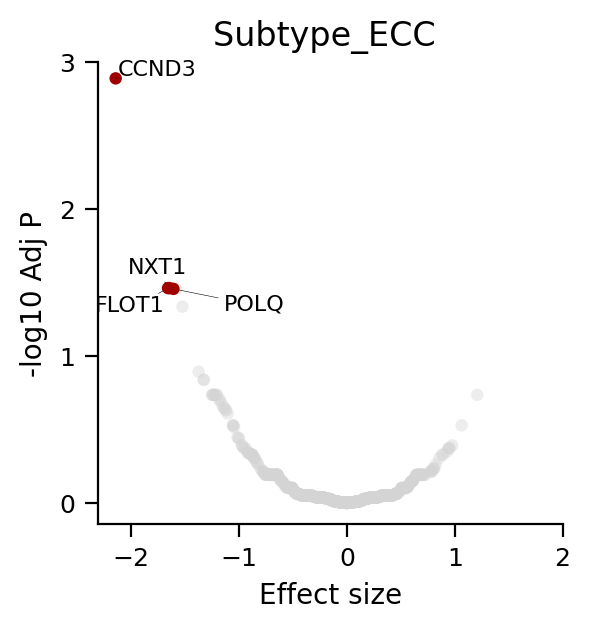


File  Figure4/output_fig4/Subtype_ECC_features_Down_.csv saved, shape: (4, 5)


In [15]:
ECC_features = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', return_features=True,  ylim_top=3, ytick_step=1, xlim_right=2, top_labels_cutoff=0)# xtick_step=2,xlim_left=-5,

## GBC

In [16]:
group =  'Subtype_GBC'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, subtype_df, test='ttest', group=group)

Subtype_GBC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/Subtype_GBC_all_features_stats.csv saved, shape: (772, 6)


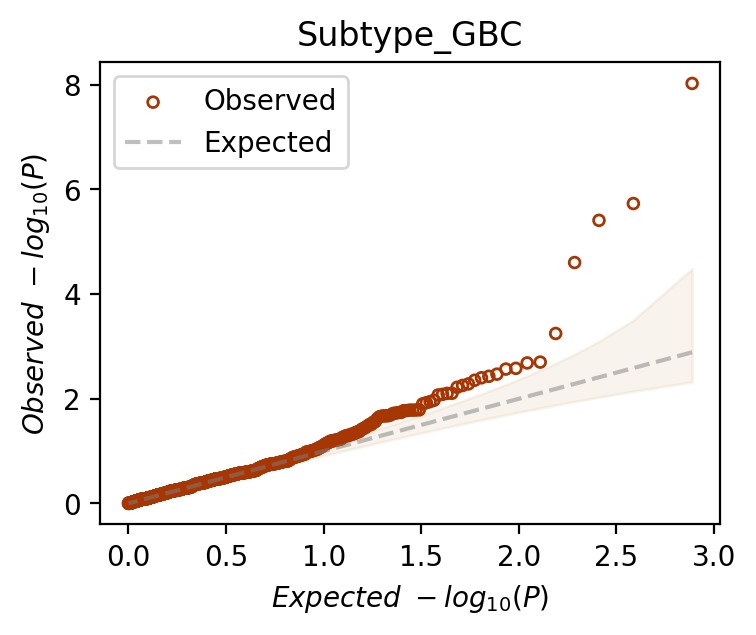

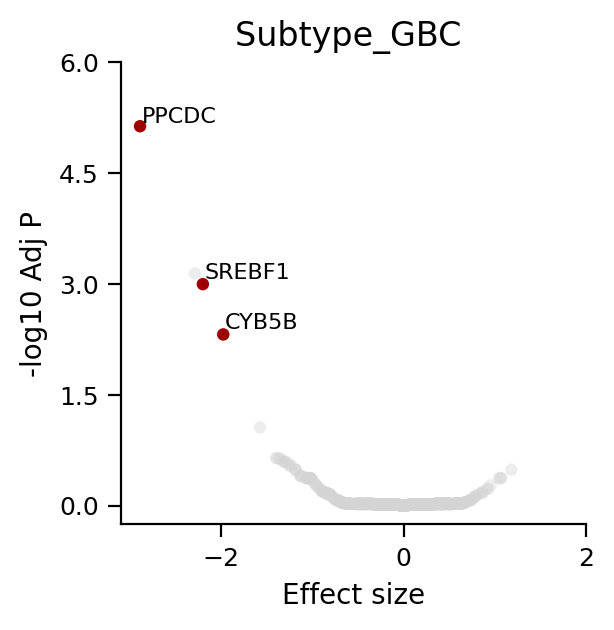


File  Figure4/output_fig4/Subtype_GBC_features_Down_.csv saved, shape: (3, 5)


In [17]:
GBC_features = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', return_features=True,  ylim_top=6, ytick_step=1.5, xlim_right=2, top_labels_cutoff=0)# xtick_step=2,xlim_left=-5,

## ICC

In [18]:
group =  'Subtype_ICC'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, subtype_df, test='ttest', group=group)

Subtype_ICC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/Subtype_ICC_all_features_stats.csv saved, shape: (772, 6)


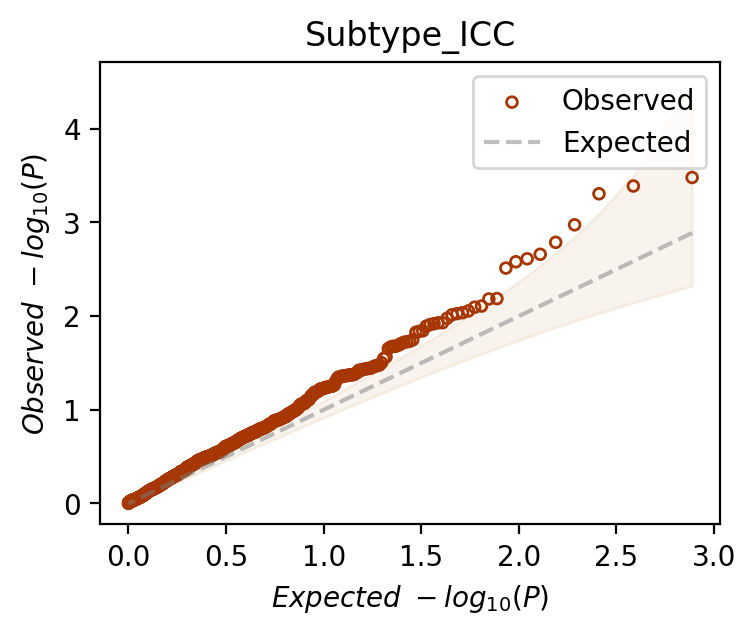

In [19]:
ICC_features = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', return_features=True,  ylim_top=6, ytick_step=1.5, xlim_right=2, top_labels_cutoff=0)# xtick_step=2,xlim_left=-5,

## HCC

In [20]:
group =  'Subtype_HCC'
res_df = DifferentialDependency.differential_dependency(gene_effect_filtered_df2, subtype_df, test='ttest', group=group)

Subtype_HCC
Number of processes: 10 -------------------------------

File  Figure4/output_fig4/Subtype_HCC_all_features_stats.csv saved, shape: (772, 6)


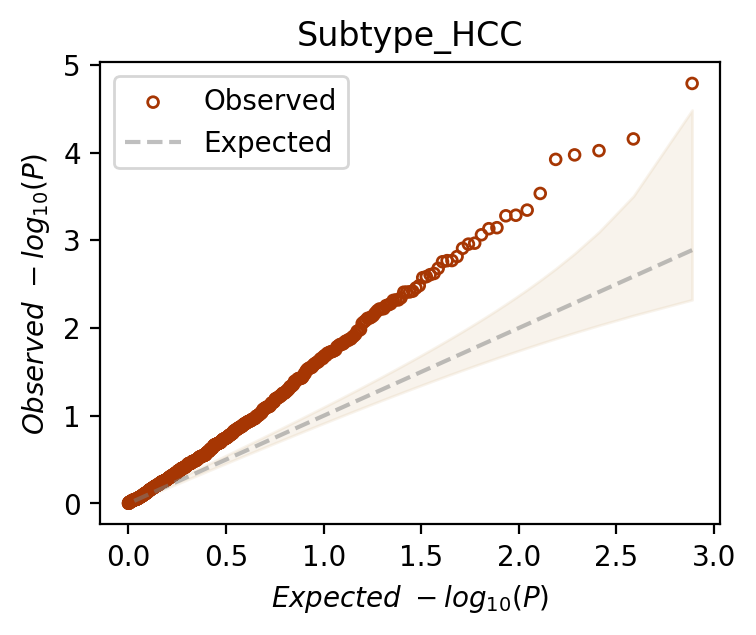

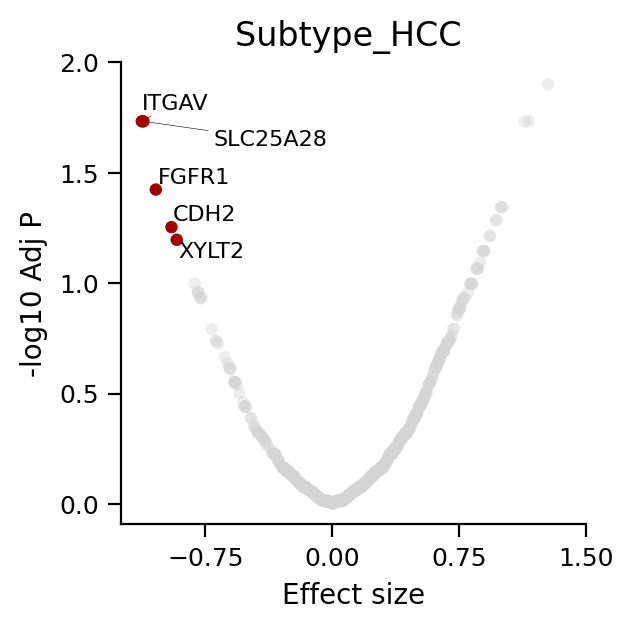


File  Figure4/output_fig4/Subtype_HCC_features_Down_.csv saved, shape: (5, 5)


In [21]:
HCC_features = DifferentialDependency.select_differential_dependency(res_df, group, in_group_col='in_group_gene_effect_mean', gene_effect_thr=None, return_features=True,  ylim_top=2, ytick_step=.5, xlim_right=1.5, xtick_step=.75, top_labels_cutoff=2)

# Heatmap of selected features

In [22]:
features_l = GBC_features+AC_features+ECC_features+HCC_features
features_l.remove('CDH2')
features_l.remove('SLC25A28')
features_l

['SREBF1',
 'CYB5B',
 'PPCDC',
 'TUBB4B',
 'TGFBR1',
 'NXT1',
 'CCND3',
 'POLQ',
 'FLOT1',
 'ITGAV',
 'XYLT2',
 'FGFR1']

Minimum value for all clusters:
Gene
SREBF1   -1.313944
TUBB4B   -1.282492
NXT1     -1.127758
ITGAV    -0.928249
CYB5B    -0.893537
PPCDC    -0.803778
TGFBR1   -0.618958
CCND3    -0.614579
POLQ     -0.604770
FLOT1    -0.505690
XYLT2    -0.457736
FGFR1    -0.416531
dtype: float64


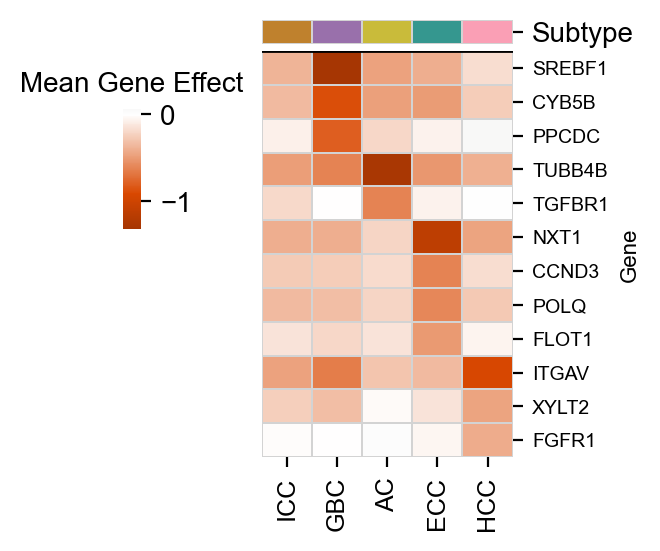

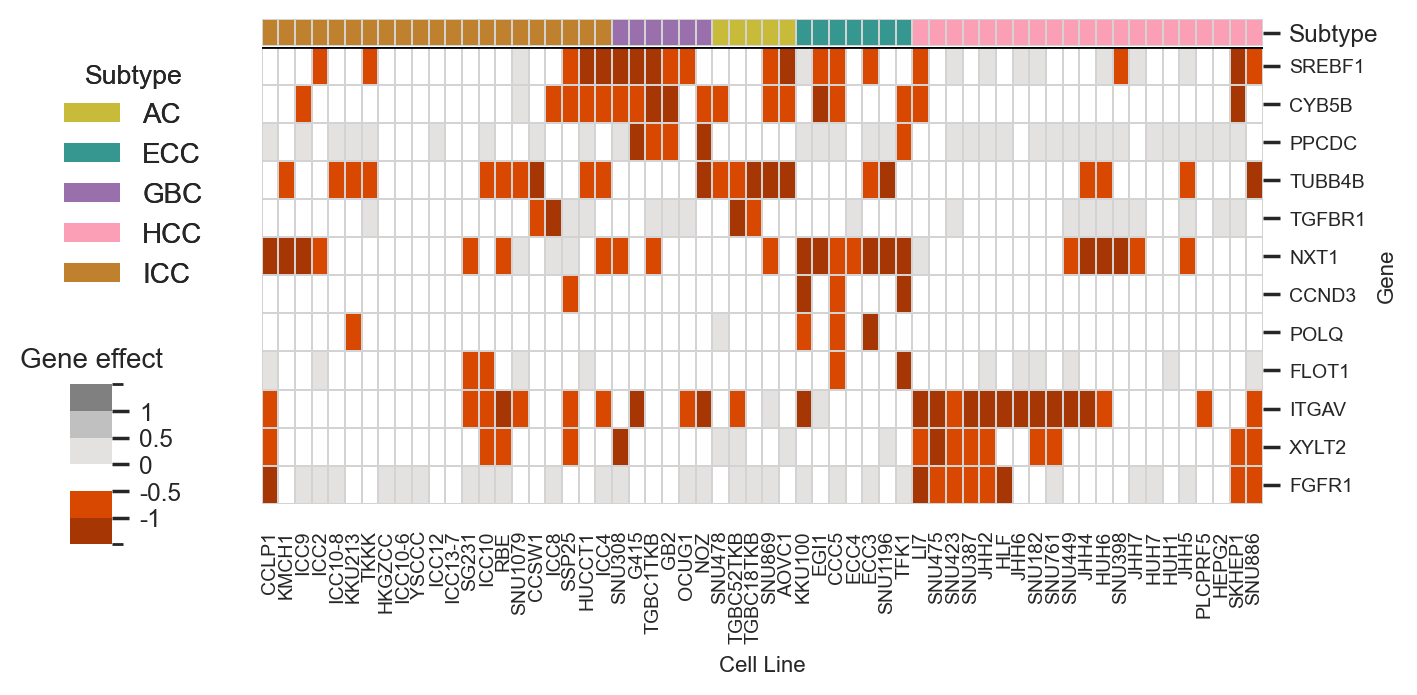

In [23]:
clusters_ordering = ['ICC', 'GBC', 'AC', 'ECC', 'HCC']
Clustering.plot_heatmaps_subtypes(gene_effect_filtered_df2.loc[:, features_l], upset_df, clusters_ordering, save_figure=True)